In [9]:
from fastai.tabular.all import *
from fastinference.tabular import *
from datetime import datetime,timedelta
from dotenv import load_dotenv
from google.cloud import bigquery
import os
sys.path.append('../')
from lib.fetcher import fetch

In [17]:
# Load secrets from environment variables to avoid showing them in shared notebook snapshots
load_dotenv(dotenv_path='/storage/.env')

# Define variables
flush = True
use_cat = False
var_viewer_login = 'chillu'
var_bigquery_table = 'silverstripe.com:api-project-617183295772.github_silverstripe_events.events_chillu'
var_date_min=(datetime.now() - timedelta(days=4*365))
var_date_max=(datetime.now() - timedelta(days=30))
var_results_path='/storage/results.csv'

In [18]:
# https://towardsdatascience.com/normalization-vs-standardization-cb8fe15082eb
def normalise(x):
    return (x-min(x))/(max(x)-min(x))

In [19]:
def preprocess(df):
    # Fill missing values with zeroes
    df = df.fillna(value=0)
    # Clip outliers in scoring inputs to provide a better range to the regression
    df['viewer_events_count'].clip(upper=3, inplace=True)
    df['viewer_comments_count'].clip(upper=3, inplace=True)
    df['viewer_comments_body_count'].clip(upper=500, inplace=True)
    return df

In [20]:
# Get subset of githubarchive.org data
# DANGER DANGER This query can cost up to $30USD
query1 = ("""
SELECT 
id, 
type, 
created_at, 
repo.name AS repo_name, 
repo.id AS repo_id, 
actor.login AS actor_login, 
actor.id AS actor_id, 
org.id AS org_id, 
org.login AS org_login, 
payload
FROM `githubarchive.day.2*`
WHERE
# Date without the leading "2" (workaround to filter out "yesterday" table naming)
_TABLE_SUFFIX BETWEEN '{var_date_min}' AND '{var_date_max}'
AND actor.login = '{var_viewer_login}'
""".format(
    var_viewer_login=var_viewer_login,
    var_date_min=var_date_max.strftime('%Y-%m-%d')[1:],
    var_date_max=var_date_max.strftime('%Y-%m-%d')[1:]
))
# TODO Create view from query1

In [21]:
query2 = ("""
# Get events with baseline analysis
SELECT
*,
(type IN ('IssueCommentEvent', 'PullRequestReviewCommentEvent', 'PullRequestCommentEvent')) AS is_comment,
(JSON_EXTRACT_SCALAR(payload, '$.action') = 'create' AND actor_login = '{var_viewer_login}') AS is_author,
(body IS NOT NULL AND body LIKE CONCAT('%@', '{var_viewer_login}', '%')) AS is_at_mentioned,
# TODO Includes @param, @return etc.
ARRAY_TO_STRING(REGEXP_EXTRACT_ALL(body, r'(?:^|\s)(@[a-zA-Z0-9-_//]+)'),',') AS at_mentions,
ARRAY_LENGTH(REGEXP_EXTRACT_ALL(body, r'(?:^|\s)(@[a-zA-Z0-9-_//]+)')) AS at_mentions_count,
CHAR_LENGTH(title) AS title_chars_count,
CHAR_LENGTH(body) AS body_chars_count,
ARRAY_LENGTH(REGEXP_EXTRACT_ALL(body, r'[#\*]')) AS markdown_chars_count
FROM (
  # Get all relevant events in relevant repos.
  # Normalise some data between types.
  SELECT
    *,
    JSON_EXTRACT_SCALAR(payload, '$.action') AS action,
    COALESCE(
      JSON_EXTRACT_SCALAR(payload, '$.issue.id'),
      JSON_EXTRACT_SCALAR(payload, '$.pull_request.id')
    ) AS item_id,
    COALESCE(
      JSON_EXTRACT_SCALAR(payload, '$.issue.url'),
      JSON_EXTRACT_SCALAR(payload, '$.pull_request.url')
    ) AS item_url,
    # TODO Keep empty for comments
    COALESCE(
      JSON_EXTRACT_SCALAR(payload, '$.issue.title'),
      JSON_EXTRACT_SCALAR(payload, '$.pull_request.title')
    ) AS title,
    COALESCE(
      JSON_EXTRACT_SCALAR(payload, '$.comment.body'),
      JSON_EXTRACT_SCALAR(payload, '$.issue.body'),
      JSON_EXTRACT_SCALAR(payload, '$.pull_request.body')
    ) AS body
  FROM `{var_bigquery_table}`
  WHERE
    repo_id IN (
      # Get all repos which the user has interacted with
      SELECT repo_id
      FROM `{var_bigquery_table}`
      WHERE
        actor_login = '{var_viewer_login}'
        AND created_at BETWEEN '{var_date_min}' AND '{var_date_max}'
      GROUP BY repo_id
    )
    AND created_at BETWEEN '{var_date_min}' AND '{var_date_max}'
    AND type IN ('IssuesEvent', 'PullRequestEvent', 'IssueCommentEvent', 'PullRequestReviewCommentEvent', 'PullRequestCommentEvent')
)
""".format(
    var_viewer_login=var_viewer_login,
    var_bigquery_table=var_bigquery_table,
    var_min_date=var_date_min.strftime('%Y-%m-%d'),
    var_date_max=var_date_max.strftime('%Y-%m-%d')
))
# TODO Create view from query2

KeyError: 'var_date_min'

In [22]:
query3 = ("""
WITH
all_events AS (
  SELECT *
  FROM `{var_bigquery_table}`
),
opened_events AS (
  SELECT *
  FROM `{var_bigquery_table}`
  WHERE type IN ('IssuesEvent', 'PullRequestEvent') AND action = 'opened' 
  ORDER BY created_at ASC
),
viewer_events AS (
  SELECT *
  FROM `{var_bigquery_table}`
  WHERE actor_login = '{var_viewer_login}'
  ORDER BY created_at ASC
),
repo_event_counts_by_actor AS (
  SELECT
  repo_id,
  actor_login,
  COUNT(*) AS event_count,
  COUNTIF(type = 'IssuesEvent' AND action = 'opened') AS issues_opened_count,
  COUNTIF(type = 'PullRequestEvent' AND action = 'opened') AS pull_requests_opened_count
  FROM `{var_bigquery_table}`
  WHERE created_at BETWEEN '{var_date_min}' AND '{var_date_max}'
  GROUP BY 1,2
)

SELECT DISTINCT
# Leading indicators (available on new items)
opened_events.item_id,
opened_events.item_url,
opened_events.org_id,
opened_events.repo_id,
opened_events.actor_login AS creator_login,
opened_events.type,
opened_events.created_at,
opened_events.is_at_mentioned,
opened_events.title_chars_count,
opened_events.body_chars_count,
opened_events.markdown_chars_count,
# Scoring indicators
repo_event_counts_by_viewer.issues_opened_count AS viewer_repo_issues_opened_count,
repo_event_counts_by_viewer.pull_requests_opened_count AS viewer_repo_pull_requests_opened_count,
repo_event_counts_by_creator.issues_opened_count AS creator_repo_issues_opened_count,
repo_event_counts_by_creator.pull_requests_opened_count AS creator_repo_pull_requests_opened_count,
COUNTIF(all_events.actor_login = '{var_viewer_login}') AS viewer_events_count,
COUNTIF(all_events.is_comment = true AND all_events.actor_login = '{var_viewer_login}') AS viewer_comments_count,
# Trailing indicators (not available on newly created items)
STRING_AGG(all_events.at_mentions) AS all_at_mentions,
STRING_AGG(all_events.actor_login) AS all_actors,
COUNT(all_events.id) AS events_count,
COUNTIF(all_events.is_comment = true) AS comments_count,
CHAR_LENGTH(STRING_AGG(all_events.body)) AS comments_body_count,
SUM(all_events.at_mentions_count) AS at_mentions_count,
COUNTIF(all_events.is_at_mentioned = true) AS viewer_at_mentions_count,
(SELECT CHAR_LENGTH(STRING_AGG(viewer_events.body)) FROM viewer_events WHERE opened_events.item_id = viewer_events.item_id) AS viewer_comments_body_count
# Due to the nature of event streams, the opened event might not be in the source data set (cutoff by date filter)
FROM opened_events
LEFT JOIN all_events
    ON all_events.item_id = opened_events.item_id
LEFT JOIN repo_event_counts_by_actor AS repo_event_counts_by_viewer
  ON repo_event_counts_by_viewer.actor_login = '{var_viewer_login}' AND opened_events.repo_id = repo_event_counts_by_viewer.repo_id
LEFT JOIN repo_event_counts_by_actor AS repo_event_counts_by_creator
  ON opened_events.actor_login = repo_event_counts_by_creator.actor_login AND opened_events.repo_id = repo_event_counts_by_creator.repo_id
WHERE opened_events.created_at BETWEEN '{var_date_min}' AND '{var_date_max}'
GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
ORDER BY opened_events.created_at ASC
""".format(
    var_viewer_login=var_viewer_login,
    var_bigquery_table=var_bigquery_table,
    var_date_min=var_date_min.strftime('%Y-%m-%d'),
    var_date_max=var_date_max.strftime('%Y-%m-%d')
))
print(query3)


WITH
all_events AS (
  SELECT *
  FROM `silverstripe.com:api-project-617183295772.github_silverstripe_events.events_chillu`
),
opened_events AS (
  SELECT *
  FROM `silverstripe.com:api-project-617183295772.github_silverstripe_events.events_chillu`
  WHERE type IN ('IssuesEvent', 'PullRequestEvent') AND action = 'opened' 
  ORDER BY created_at ASC
),
viewer_events AS (
  SELECT *
  FROM `silverstripe.com:api-project-617183295772.github_silverstripe_events.events_chillu`
  WHERE actor_login = 'chillu'
  ORDER BY created_at ASC
),
repo_event_counts_by_actor AS (
  SELECT
  repo_id,
  actor_login,
  COUNT(*) AS event_count,
  COUNTIF(type = 'IssuesEvent' AND action = 'opened') AS issues_opened_count,
  COUNTIF(type = 'PullRequestEvent' AND action = 'opened') AS pull_requests_opened_count
  FROM `silverstripe.com:api-project-617183295772.github_silverstripe_events.events_chillu`
  WHERE created_at BETWEEN '2016-09-14' AND '2020-08-14'
  GROUP BY 1,2
)

SELECT DISTINCT
# Leading indicators

In [23]:
# Fetch results if not already present
if flush == True or not os.path.isfile(var_results_path):
    client = bigquery.Client()
    df = client.query(query3).to_dataframe()
    df.to_csv(var_results_path)
else:
    df = pd.read_csv(var_results_path)

In [24]:
# Preview raw data
pd.set_option('display.max_columns', None)
df.head()

,item_id,item_url,org_id,repo_id,creator_login,type,created_at,is_at_mentioned,title_chars_count,body_chars_count,markdown_chars_count,viewer_repo_issues_opened_count,viewer_repo_pull_requests_opened_count,creator_repo_issues_opened_count,creator_repo_pull_requests_opened_count,viewer_events_count,viewer_comments_count,all_at_mentions,all_actors,events_count,comments_count,comments_body_count,at_mentions_count,viewer_at_mentions_count,viewer_comments_body_count
0,176782203,https://api.github.com/repos/silverstripe/silverstripe-asset-admin/issues/251,379348.0,42913926,chillu,IssuesEvent,2016-09-14 00:06:58+00:00,False,74,1488.0,0.0,40.0,16.0,40,16,3,1,",,,","chillu,chillu,flamerohr,chillu",4,2,3926.0,0.0,0,3388.0
1,85159970,https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/6002,379348.0,1318892,chillu,PullRequestEvent,2016-09-14 03:07:32+00:00,False,35,170.0,0.0,120.0,124.0,120,124,2,0,",","chillu,chillu",2,0,341.0,0.0,0,341.0
2,85160347,https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/6003,379348.0,1318892,clarkepaul,PullRequestEvent,2016-09-14 03:13:09+00:00,False,43,363.0,0.0,120.0,124.0,48,13,1,0,",","clarkepaul,chillu",2,0,727.0,0.0,0,363.0
3,176812424,https://api.github.com/repos/silverstripe/silverstripe-framework/issues/6004,379348.0,1318892,clarkepaul,IssuesEvent,2016-09-14 04:31:50+00:00,False,49,111.0,0.0,120.0,124.0,48,13,0,0,",,,","tractorcow,clarkepaul,flamerohr,tractorcow",4,2,377.0,0.0,0,NaN
4,85165423,https://api.github.com/repos/silverstripe/silverstripe-frameworktest/pulls/23,379348.0,1296840,chillu,PullRequestEvent,2016-09-14 04:32:14+00:00,False,26,87.0,0.0,6.0,17.0,6,17,1,0,",","dhensby,chillu",2,0,175.0,0.0,0,87.0


In [25]:
# Duplicate any items without "temporal" data.
# The model should be able to perform well on newly created issues
# without penalising them for not having any events (yet)
temporal_overrides = {
  'events_count': 0,
  'comments_count': 0,
  'comments_body_count': 0,
}
df_fresh = df.copy().assign(**temporal_overrides)
# Avoid index clashes and make altered rows identifiable during validation
df_fresh['item_url'] = df_fresh['item_url']  + '__fresh'
df = df.append(df_fresh)
df = df.set_index('item_url')

In [26]:
df = preprocess(df)

In [27]:
# Preview some values used for scoring
scoring = {
#     'viewer_events_count': 1, 
#     'viewer_comments_count': 2, 
    'viewer_comments_body_count': 1
}
scoring_fields = list(scoring.keys())

<AxesSubplot:>

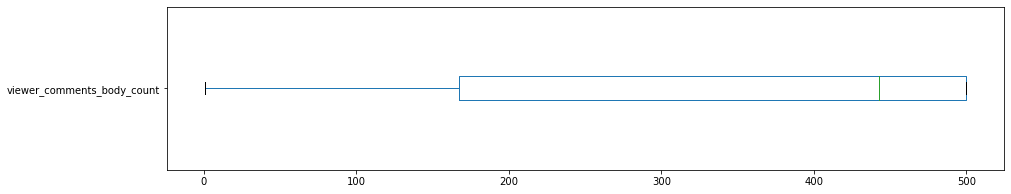

In [28]:
# Explore data distribution to get intuition on scoring
# Even after removing outliers in preprocessing,
# the two ranges have very different dimensionality without normalisation.
df[scoring_fields].where(df[scoring_fields] > 0).plot.box(vert=False,figsize=(15,3))

<AxesSubplot:>

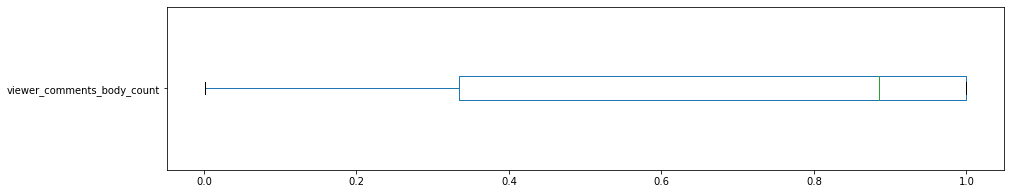

In [29]:
# Naive min-max normalisation to avoid one feature overly influencing the scoring
df[scoring_fields] = df[scoring_fields].apply(normalise)
df[scoring_fields].where(df[scoring_fields] > 0).plot.box(vert=False,figsize=(15,3))

In [30]:
# Calculate score with different weights
# TODO Use apply() and add()
scoring_weights = list(scoring.values())
df['score'] = normalise(
    df[scoring_fields[0]] * scoring_weights[0]
#     + df[scoring_fields[1]] * scoring_weights[1]
#     + df[scoring_fields[2]] * scoring_weights[2]
)
df[scoring_fields + ['score']].sort_values(by='score', ascending=False).head()

# Optionally use score as a categorical value, lower fidelity but also lower noise
if use_cat:
    df['score'] = df['score'].apply(lambda x: 1 if x > 0 else 0)

<AxesSubplot:>

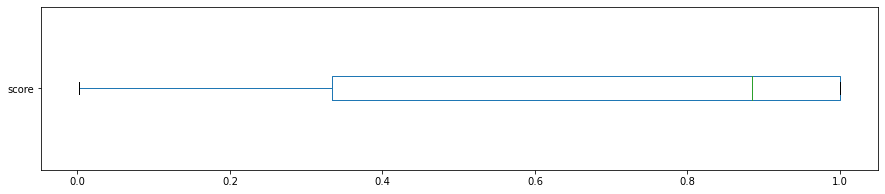

In [31]:
# Scoring distribution (excl. zeroes)
# It's skewed to lower scores, since low interactions are more common than high interactions
df['score'].where(df['score'] > 0).plot.box(vert=False,figsize=(15,3))

<AxesSubplot:ylabel='Frequency'>

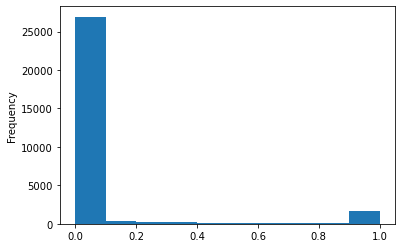

In [32]:
# Scoring histogram (incl. zeroes)
# There are way more items where the actor has never interacted (score=0)
df['score'].plot.hist()

In [33]:
# Percentage of rows where score=0
len(df[df['score'] == 0]) / len(df)

0.8889847951663237

In [34]:
# Don't include scoring_fields in here since that would be cheating
cat_names = [
  'org_id',
  'repo_id',
  'creator_login',
#   'type',
#   'is_at_mentioned',
]
cont_names = [
#   'title_chars_count',
#   'body_chars_count',
#   'markdown_chars_count',
#   'viewer_repo_issues_opened_count',
#   'viewer_repo_pull_requests_opened_count',
#   'creator_repo_issues_opened_count',
#   'creator_repo_pull_requests_opened_count',
#   'events_count',
#   'comments_count',
#   'comments_body_count',
#   'viewer_at_mentions_count',
#   'at_mentions_count',
]

In [35]:
# Create fast.ai (PyTorch) data set
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
tp = TabularPandas(
    df,
    cat_names=cat_names,
    cont_names=cont_names,
    procs=[
      FillMissing,
      Categorify,
      Normalize
    ],
    y_names='score',
    # Optionally use score as a categorical value, lower fidelity but also lower noise
    y_block=CategoryBlock if use_cat else None,
    splits=splits
)

In [36]:
# Alternative approach: Decision trees
# Couldn't get accuracy above 0.51
# from sklearn import ensemble
# xs,y = tp.train.xs,tp.train.y
# valid_xs,valid_y = tp.valid.xs,tp.valid.y
# def rf(n_estimators=1000, max_samples=20000,
#        max_features=0.5, min_samples_leaf=20, **kwargs):
#     return ensemble.RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
#         max_samples=max_samples, max_features=max_features,
#         min_samples_leaf=min_samples_leaf, oob_score=True)
# model = rf()
# model.fit(xs, y)
# model.score(valid_xs, valid_y)

In [37]:
learn = tabular_learner(tp.dataloaders(bs=64), metrics=accuracy)

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=1.9054607491852948e-06)

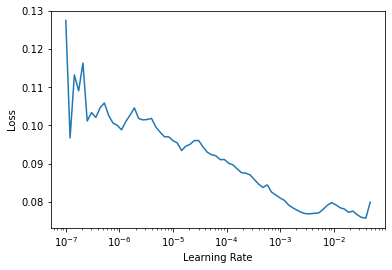

In [38]:
# Intuit the learning rate
learn.lr_find()

In [39]:
learn.fit_one_cycle(1, lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.038602,0.037676,0.890106,00:05


In [40]:
learn.show_results()

,org_id,repo_id,creator_login,score,score_pred
0,4.0,21.0,350.0,0.0,0.049475
1,4.0,20.0,277.0,1.0,0.088244
2,8.0,74.0,579.0,0.0,-0.004491
3,4.0,20.0,521.0,0.0,0.095061
4,13.0,29.0,269.0,0.0,0.019207
5,4.0,99.0,267.0,1.0,0.738244
6,4.0,20.0,768.0,0.0,0.230821
7,4.0,18.0,768.0,0.0,0.045684
8,4.0,102.0,650.0,0.0,0.061512


In [105]:
interp = Interpretation.from_learner(learn)
top_losses = interp.top_losses()
to_top_losses = learn.dls.valid.dataset.iloc[top_losses.indices]
df_top_losses = to_top_losses.decode().items
df_top_losses['loss'] = top_losses.values
df_top_losses[cat_names + cont_names + ['score', 'loss']]

,org_id,repo_id,actor_login,score,loss
item_url,,,,,
https://api.github.com/repos/silverstripe/silverstripe-cms/issues/2227__fresh,379348,1319183,kinglozzer,1.0,1.024026e+00
https://api.github.com/repos/dnadesign/silverstripe-elemental/issues/269__fresh,2.14831e+06,23339883,brynwhyman,1.0,1.021998e+00
https://api.github.com/repos/silverstripe/silverstripe-admin/pulls/58,379348,84500508,flamerohr,1.0,1.021730e+00
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/7791,379348,1318892,andrewandante,1.0,1.003415e+00
https://api.github.com/repos/silverstripe/silverstripe-mfa/issues/36,379348,172815373,brynwhyman,1.0,9.982002e-01
...,...,...,...,...,...
https://api.github.com/repos/silverstripe/silverstripe-postgresql/pulls/81,379348,1236928,robbieaverill,0.0,6.710071e-08
https://api.github.com/repos/silverstripe/silverstripe-postgresql/pulls/82,379348,1236928,robbieaverill,0.0,6.710071e-08
https://api.github.com/repos/silverstripe/silverstripe-intercom/pulls/16__fresh,379348,51967116,lexakami,0.0,2.519786e-08


In [104]:
dl_train = learn.dls[1]
_,_,preds = learn.get_preds(dl=dl_train, with_decoded=True)
df_train = dl_train.all_cols
df_train['score_pred'] = preds
df_train
#learn.dls.show_results(b, preds)

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [30]:
# Validate with a new (previously unseen) test data set
test_data = fetch(
    url='https://github.com/silverstripe/silverstripe-framework/pull/9572',
    user='chillu',
    github_api_token=os.getenv('GITHUB_API_TOKEN')
)
# Remove fields not used in model
del test_data['all_actors']
del test_data['all_at_mentions']
del test_data['item_url']
# Create fields missing from test data
test_data['prev_repo_creator_events_count'] = 1000
test_data['prev_repo_actor_events_count'] = 1000
test_data['total_repo_creator_events_count'] = 1000
test_data['total_repo_actor_events_count'] = 1000
# Create DataFrame
test_df = pd.DataFrame.from_dict([test_data])
# Reapply preprocessing
test_df = preprocess(test_df)
test_df.head()

,item_id,repo_id,org_id,actor_login,type,is_comment,title_chars_count,body_chars_count,markdown_chars_count,at_mentions_count,is_author,is_at_mentioned,actor_at_mentions_count,events_count,actor_events_count,comments_count,comments_body_count,actor_comments_count,actor_comments_body_count,prev_repo_creator_events_count,prev_repo_actor_events_count,total_repo_creator_events_count,total_repo_actor_events_count
0,443205968,1318892,379348,sminnee,PullRequestEvent,False,50,587,3,13,False,True,1,43,3,43,27202,3,500,1000,1000,1000,1000


In [31]:
row, pred, probs = learn.predict(test_df.iloc[0])
row.show()
pred

,org_id,repo_id,actor_login,score
0,379348,1318892,sminnee,0.219303


tensor([0.2193])

In [ ]:
learn.export('/storage/model.pkl')